In [13]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import math
import pickle
from scipy.special import softmax
from sklearn.model_selection import train_test_split



class MyNeuralNetwork():
    """
    My implementation of a Neural Network Classifier.
    """
    

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        """
        Initializing a new MyNeuralNetwork object

        Parameters
        ----------
        n_layers : int value specifying the number of layers

        layer_sizes : integer array of size n_layers specifying the number of nodes in each layer

        activation : string specifying the activation function to be used
                     possible inputs: relu, sigmoid, linear, tanh

        learning_rate : float value specifying the learning rate to be used

        weight_init : string specifying the weight initialization function to be used
                      possible inputs: zero, random, normal

        batch_size : int value specifying the batch size to be used

        num_epochs : int value specifying the number of epochs to be used
        """
        self.n_layers = 0
        self.layer_sizes = []
        self.activation = 'relu'
        self.learning_rate = 0.01
        self.weight_init = 'random'
        self.batch_size = 100
        self.num_epochs = 10
        self.acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
        self.weight_inits = ['zero', 'random', 'normal']
        self.W = []
        self.B = []
        self.losses_train= []
        self.accuracies_train = []
        self.losses_test= []
        self.accuracies_test = []
        self.fun = None
        self.fun_grad = None
        if activation not in self.acti_fns:
            raise Exception('Incorrect Activation Function')

        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')
        self.n_layers = n_layers
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.activation = activation

        if (n_layers != len(layer_sizes)):
            raise Exception('Wrong parameters layers and their sizes')


    def RELU(self, a):
        return max(0.0, a)

    def RELU_diff(self, a):
        if a > 0:
            return 1.0
        else:
            return 0.0

    def relu(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # f = np.vectorize(self.RELU)
        # return f(X)
        return (X>0)*X

    def relu_grad(self, X):
        """
        Calculating the gradient of ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # f = np.vectorize(self.RELU_diff)
        # return f(X)
        return (X>0)*1

    def sig(self, a):
        return 1/(1+math.exp(-1*a))

    def sig_diff(self, a):
        return self.sig(a)*(1-self.sig(a))

    def sigmoid(self, X):
        """
        Calculating the Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # f = np.vectorize(self.sig)
        # return f(X)
        return 1.0 / (1+np.exp(-X))

    def sigmoid_grad(self, X):
        """
        Calculating the gradient of Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # f = np.vectorize(self.sig_diff)
        # return f(X)

        sigma = self.sigmoid(X)
        return sigma*(1-sigma)

    def linear(self, X):
        """
        Calculating the Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        X = np.clip(X,-1000,1000)
        return X

    def linear_grad(self, X):
        """
        Calculating the gradient of Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return np.ones((X.shape[0],X.shape[1]))

    def tan(self, a):
        return (math.exp(a)-math.exp(-1*a))/(math.exp(a)+math.exp(-1*a))

    def tan_diff(self, a):
        return 1 - (self.tan(a))**2

    def tanh(self, X):
        """
        Calculating the Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return np.tanh(X)

    def tanh_grad(self, X):
        """
        Calculating the gradient of Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return 1- (self.tanh(X))**2

    def softmax(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        if (self.activation == 'linear'):
        	X = np.clip(X,-1000,1000)
        exps = np.exp(X-X.max())
        return exps / np.sum(exps,axis=1)[:,None]

    def softmax_grad(self, X):
        """
        Calculating the gradient of Softmax activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return None

    def zero_init(self, shape):
        """
        Calculating the initial weights after Zero Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        return np.zeroes(shape)

    def random_init(self, shape):
        """
        Calculating the initial weights after Random Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        return np.random.rand(shape[0],shape[1]) * 0.01

    def normal_init(self, shape):
        """
        Calculating the initial weights after Normal(0,1) Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        return np.random.normal(scale=1,size=(shape[0],shape[1])) * 0.01

    def fit(self, X, y,test_X =[],test_Y= []):
        """
        Fitting (training) the linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

        Returns
        -------
        self : an instance of self
        """

        # fit function has to return an instance of itself or else it won't work with test.py
        # train_X,test_X,train_Y,test_Y = train_test_split(X, y, test_size=0.2, stratify=y)
        if self.weight_init == 'normal':
            for i in range(self.n_layers-1):
                self.W.append(self.normal_init((self.layer_sizes[i], self.layer_sizes[i+1])))
                self.B.append(self.normal_init((1,self.layer_sizes[i+1])))
        elif self.weight_init == 'random':
            for i in range(self.n_layers-1):
                self.W.append(self.random_init((self.layer_sizes[i], self.layer_sizes[i+1])))
                self.B.append(self.random_init((1,self.layer_sizes[i+1])))
        elif self.weight_init == 'zero':
            for i in range(self.n_layers-1):
                self.W.append(self.zero_init((self.layer_sizes[i], self.layer_sizes[i+1])))
                self.B.append(self.zero_init((1,self.layer_sizes[i+1])))

        if self.activation == 'relu':
            self.fun = self.relu
            self.fun_grad = self.relu_grad  
        if self.activation == 'sigmoid':
            self.fun = self.sigmoid
            self.fun_grad = self.sigmoid_grad
        if self.activation == 'tanh':
            self.fun = self.tanh
            self.fun_grad = self.tanh_grad
        if self.activation == 'linear':
            self.fun = self.linear
            self.fun_grad = self.linear_grad
        if self.activation == 'softmax':
            self.fun = self.softmax
            self.fun_grad = self.softmax_grad
        for i in range(self.num_epochs):
            print(i)
            for j in range(max(len(train_X)//self.batch_size,1)):
                print(j)
                z, a = self.forward_propogation(train_X[j*self.batch_size:(j+1)*self.batch_size],self.fun)
                self.backward_propogation(z, a, train_X[j*self.batch_size:(j+1)*self.batch_size], train_Y[j*self.batch_size:(j+1)*self.batch_size],self.fun_grad)
            self.accuracies_train.append(self.score(train_X, train_Y))
            self.losses_train.append(self.log_loss(train_X,train_Y))
            self.accuracies_test.append(self.score(test_X, test_Y))
            self.losses_test.append(self.log_loss(test_X,test_Y))

            print(self.accuracies_train)
            print(self.accuracies_test)
            print(self.losses_train)
            print(self.losses_test)
        return self

    def predict_proba(self, X):
        """
        Predicting probabilities using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 2-dimensional numpy array of shape (n_samples, n_classes) which contains the 
            class wise prediction probabilities.
        """

        # return the numpy array y which contains the predicted values
        z,a = self.forward_propogation(X,self.fun)
        return a[-1]

    def predict(self, X):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
        """

        # return the numpy array y which contains the predicted values
        z, a = self.forward_propogation(X,self.fun)
        prediction = np.argmax(a[-1],axis=1)
        return prediction

    def log_loss(self,X,y):
        loss = 0
        z, a = self.forward_propogation(X,self.fun)
        print(a[-1])

        loss = -1*np.mean(y*np.log(a[-1]+10**(-10)))
        return loss

    def score(self, X, y):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as testing labels.

        Returns
        -------
        acc : float value specifying the accuracy of the model on the provided testing set
        """

        # return the numpy array y which contains the predicted values
        prediction = self.predict(X)
        # print(y)
        count = 0
        print(prediction,prediction.shape)
        for i in range(len(prediction)):
            if y[i][prediction[i]]==1:
                count += 1
        return count/len(prediction)*100

    def forward_propogation(self, train_X, func):
        Z = []
        A = []
        for i in range(0, self.n_layers-1):
            if i == 0:
                Z.append(np.dot(train_X,self.W[i])+self.B[i])
                A.append(func(Z[-1]))
            elif i != self.n_layers-2:
                Z.append(np.dot(A[i-1],self.W[i])+self.B[i])
                A.append(func(Z[-1]))
            else:
                Z.append(np.dot(A[i-1],self.W[i])+self.B[i])
                A.append(self.softmax(Z[-1]))
                # print(Z[-1])
                # print(A[-1])
                # print(np.sum(A[-1],axis=1))

        return Z, A

    def backward_propogation(self, Z, A, train_X, train_Y ,func_grad):
        n = len(train_Y)
        Grad_W = []
        Grad_B = []
        for i in range(self.n_layers-2, -1, -1):
            if (i == self.n_layers-2):
                dZ2 = A[i]-train_Y
                Grad_W.insert(0, np.dot(A[i-1].T,dZ2)/n)
                Grad_B.insert(0, np.sum(dZ2, axis=0)/n)
            elif (i != 0):
                dZ = np.multiply(np.dot(dZ2,self.W[i+1].T), func_grad(Z[i]))
                Grad_W.insert(0, np.dot(A[i-1].T,dZ)/n)
                Grad_B.insert(0, np.sum(dZ, axis=0)/n)
                dZ2 = dZ
            else:
                dZ = np.multiply(np.dot(dZ2,self.W[i+1].T), func_grad(Z[i]))
                Grad_W.insert(0, np.dot(train_X.T,dZ)/n)
                Grad_B.insert(0, np.sum(dZ, axis=0)/n)
        for i in range(0, self.n_layers-1):
            self.W[i] = self.W[i]-self.learning_rate*Grad_W[i]
            self.B[i] = self.B[i]-self.learning_rate*Grad_B[i]
    def print_loss_and_acc(self):
      print("model = ",self.activation)
      print("train_loss = ",self.losses_train[-1])
      print("test_loss = ",self.losses_test[-1])
      print("train_accuracy = ",self.accuracies_train[-1])
      print("test_accuracy = ",self.accuracies_test[-1])


if __name__ == '__main__':
    mnist = fetch_openml('mnist_784')
    x = mnist.data
    y = mnist.target
    x = x.astype(dtype='int32')
    y = y.astype(dtype='int32')

    x_sk_train, x_sk_test,y_sk_train, y_sk_test = train_test_split(x, y, test_size=0.2, stratify=y)
    hot_y = np.zeros((y.shape[0],10))
    hot_y[np.arange(y.shape[0]),y]=1
    train_X,test_X,train_Y,test_Y = train_test_split(x, hot_y, test_size=0.2, stratify=hot_y)

    # model = MyNeuralNetwork(
    #      5, [784, 256, 128, 64, 10], 'relu', 0.1, 'normal', 7000, 100)
    # model = model.fit(train_X, train_Y,test_X,test_Y)
    # print(model.predict(test_X))
    # print(model.score(test_X,test_Y))

    # f = "model_relu"
    # pickle.dump(model,open(f,'wb'))

    # model_2 = MyNeuralNetwork(
    #      5, [784, 256, 128, 64, 10], 'tanh', 0.1, 'normal', 7000, 100)
    # model_2 = model_2.fit(train_X, train_Y,test_X,test_Y)
    # print(model_2.predict(test_X))
    # print(model_2.score(test_X,test_Y))

    # f = "model_tanh"

    # pickle.dump(model_2,open(f,'wb'))

    # model_3 = MyNeuralNetwork(
    #      5, [784, 256, 128, 64, 10], 'sigmoid', 0.1, 'normal', 700, 100)
    # model_3 = model_3.fit(train_X, train_Y,test_X,test_Y)
    # print(model_3.predict(test_X))
    # print(model_3.score(test_X,test_Y))

    # f = "model_sigmoid"

    # pickle.dump(model_3,open(f,'wb'))

    # model_4 = MyNeuralNetwork(
    #      5, [784, 256, 128, 64, 10], 'linear', 0.1, 'normal', 7000, 100)
    # model_4 = model_4.fit(train_X, train_Y,test_X,test_Y)
    # print(model_4.predict(test_X))
    # print(model_4.score(test_X,test_Y))

    # f = "model_linear"

    # pickle.dump(model_4,open(f,'wb'))



    # model_3 = MyNeuralNetwork(
    #     5, [784, 256, 128, 64, 10], 'sigmoid', 0.1, 'normal', 700, 100)
    # model_3.fit(train_X, train_Y)
    # model_3.predict(test_X,test_Y)
    # model_3.score(test_X,test_Y)

    # # f = "model_tanh.sav"
    # # pickle.dump(model_2,open(f,'wb'))

    # # c = pickle.load(open(f,'rb'))
    # # c.print_loss_and_acc()

    # # model_3 = MyNeuralNetwork(
    # #     5, [784, 256, 128, 64, 10], 'sigmoid', 0.1, 'normal', 700, 100)
    # # model_3.fit(x, hot_y)
    # # f = "model_sigmoid.sav"
    # # pickle.dump(model_3,open(f,'wb'))

    # # c = pickle.load(open(f,'rb'))
    # # c.print_loss_and_acc()

    # model_4 = MyNeuralNetwork(
    #     5, [784, 256, 128, 64, 10], 'linear', 0.1, 'normal', 7000, 100)
    # model_4.fit(x, hot_y)
    # f = "model_linear.sav"
    # pickle.dump(model_4,open(f,'wb'))

    c = pickle.load(open("model_relu",'rb'))
    c.print_loss_and_acc()
    

model =  relu
train_loss =  0.23011309536363792
test_loss =  0.2301144738577101
train_accuracy =  11.257142857142858
test_accuracy =  11.25


In [3]:
relu_mod = pickle.load(open("model_relu",'rb'))
relu_mod.print_loss_and_acc()

model =  relu
train_loss =  0.23011309536363792
test_loss =  0.2301144738577101
train_accuracy =  11.257142857142858
test_accuracy =  11.25


In [4]:
tanh_mod = pickle.load(open("model_tanh",'rb'))
tanh_mod.print_loss_and_acc()

model =  tanh
train_loss =  0.009643408933340529
test_loss =  0.015840815082557153
train_accuracy =  97.77678571428572
test_accuracy =  95.60714285714286


In [5]:
sigmoid_mod = pickle.load(open("model_sigmoid",'rb'))
sigmoid_mod.print_loss_and_acc()

model =  sigmoid
train_loss =  0.023873471866821584
test_loss =  0.029048831542912566
train_accuracy =  93.7982142857143
test_accuracy =  92.64285714285714


In [6]:
linear_mod = pickle.load(open("model_linear",'rb'))
linear_mod.print_loss_and_acc()

model =  linear
train_loss =  0.7693067452620277
test_loss =  0.7598268740391454
train_accuracy =  20.97142857142857
test_accuracy =  21.014285714285712


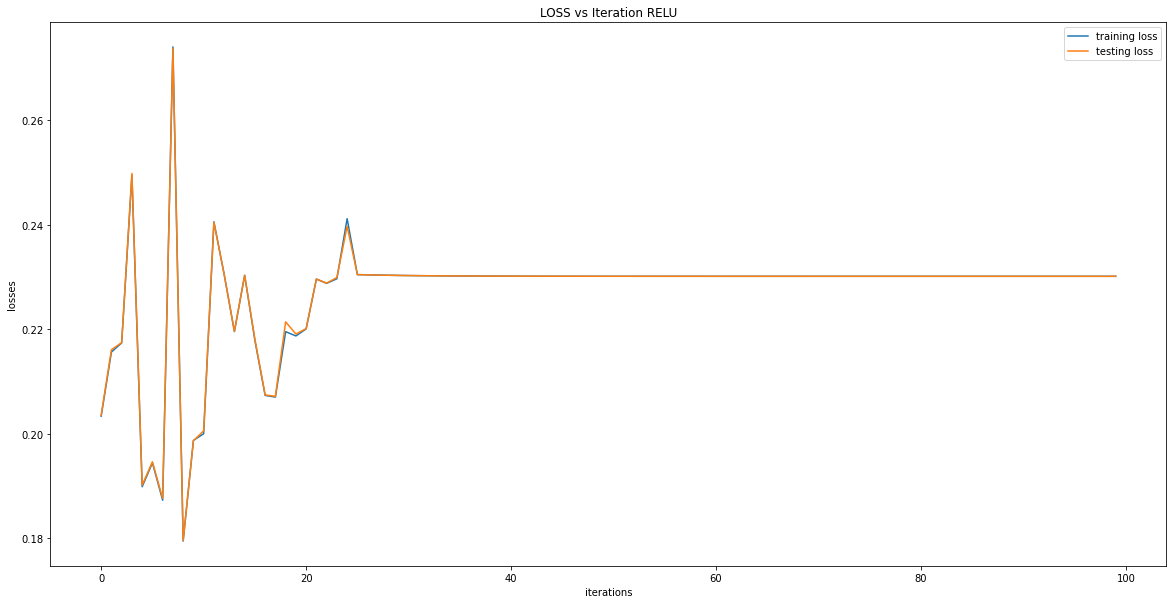

In [7]:
from matplotlib import pyplot as plt
relu_mod = pickle.load(open("model_relu",'rb'))
plt.figure(figsize=(20,10))
plt.xlabel('iterations')
plt.ylabel('losses')
plt.title('LOSS vs Iteration RELU')
plt.plot(relu_mod.losses_train, label = "training loss")
plt.plot(relu_mod.losses_test, label = "testing loss")
plt.legend()
plt.show()

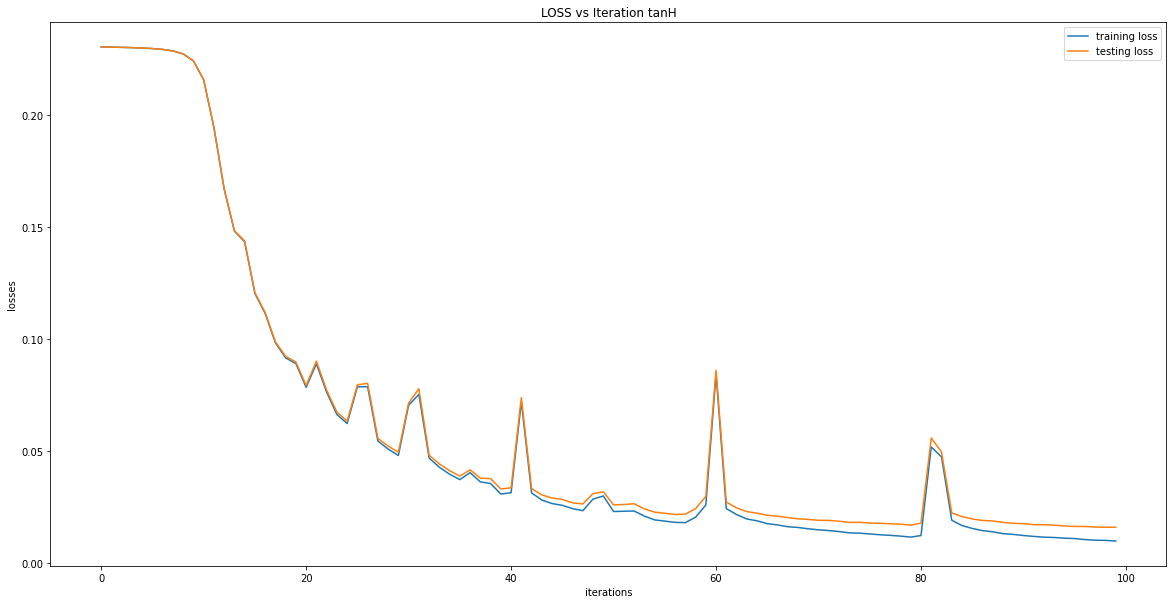

In [8]:
from matplotlib import pyplot as plt
relu_mod = pickle.load(open("model_tanh",'rb'))
plt.figure(figsize=(20,10))
plt.xlabel('iterations')
plt.ylabel('losses')
plt.title('LOSS vs Iteration tanH')
plt.plot(relu_mod.losses_train, label = "training loss")
plt.plot(relu_mod.losses_test, label = "testing loss")
plt.legend()
plt.show()

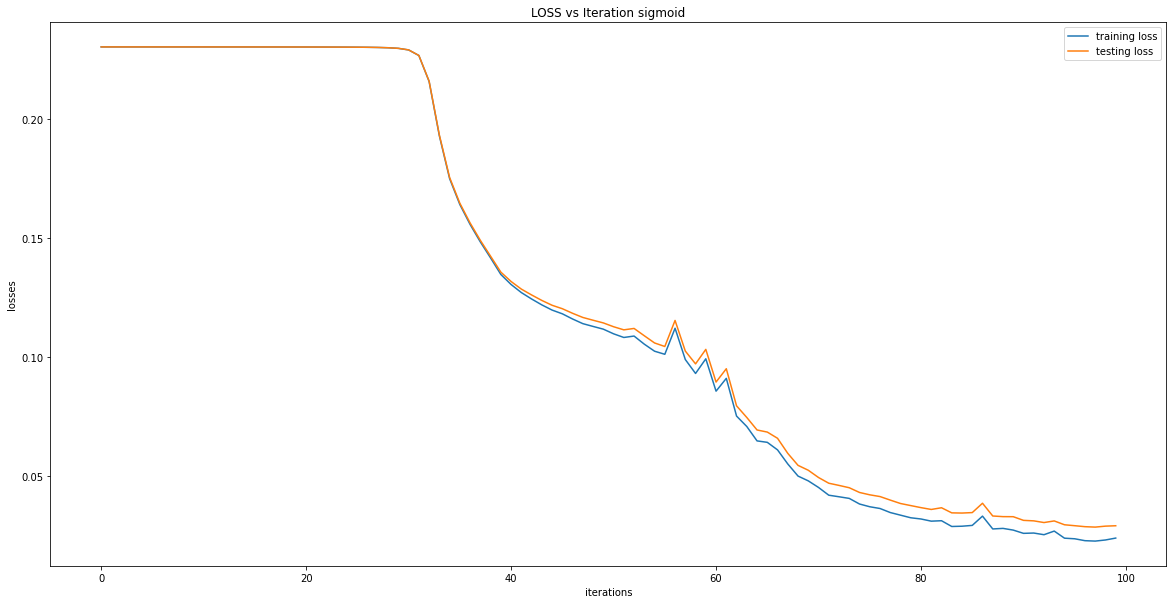

In [9]:
from matplotlib import pyplot as plt
relu_mod = pickle.load(open("model_sigmoid",'rb'))
plt.figure(figsize=(20,10))
plt.xlabel('iterations')
plt.ylabel('losses')
plt.title('LOSS vs Iteration sigmoid')
plt.plot(relu_mod.losses_train, label = "training loss")
plt.plot(relu_mod.losses_test, label = "testing loss")
plt.legend()
plt.show()

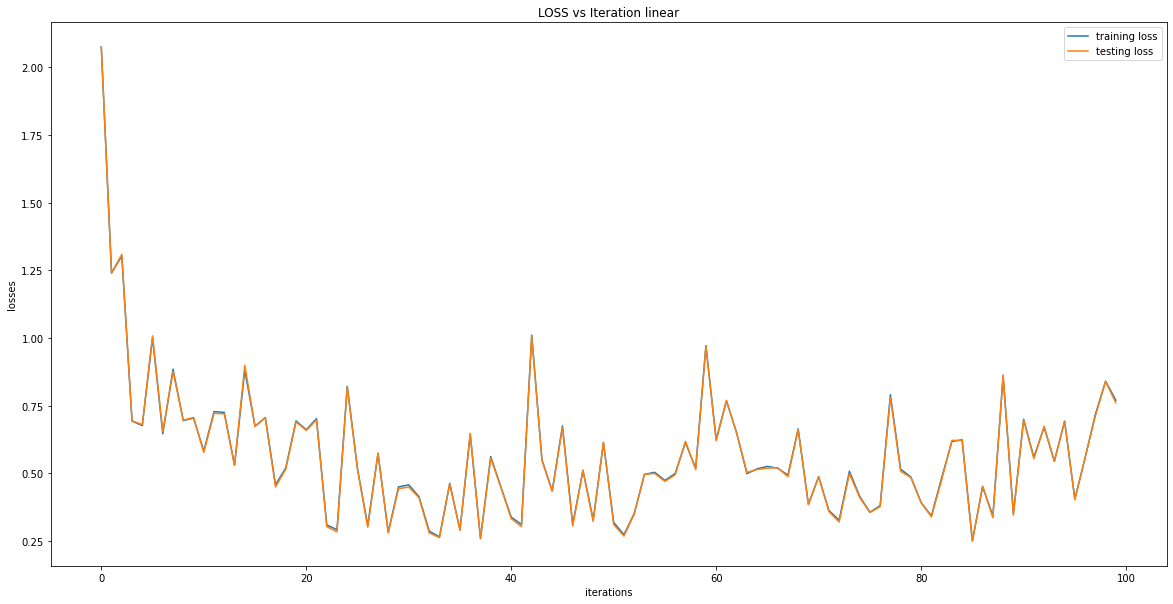

In [10]:
from matplotlib import pyplot as plt
relu_mod = pickle.load(open("model_linear",'rb'))
plt.figure(figsize=(20,10))
plt.xlabel('iterations')
plt.ylabel('losses')
plt.title('LOSS vs Iteration linear')
plt.plot(relu_mod.losses_train, label = "training loss")
plt.plot(relu_mod.losses_test, label = "testing loss")
plt.legend()
plt.show()

In [11]:
from sklearn.neural_network import MLPClassifier

activation_functions = ["relu","logistic","tanh","identity"]

In [14]:
for s in activation_functions:
  mod_sk = MLPClassifier(hidden_layer_sizes =(256,128,64),activation=s,solver='sgd',
                         max_iter=100,alpha=0,batch_size=7000,learning_rate_init=0.1,
                         learning_rate='constant')
  mod_sk = mod_sk.fit(x_sk_train,y_sk_train)
  print(s)
  print('training_accuracy = ',mod_sk.score(x_sk_train,y_sk_train))
  print('testing_accuracy = ',mod_sk.score(x_sk_test,y_sk_test))

relu
training_accuracy =  0.11253571428571428
testing_accuracy =  0.1125


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic
training_accuracy =  0.99
testing_accuracy =  0.9645714285714285


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh
training_accuracy =  0.9660535714285714
testing_accuracy =  0.9575714285714285


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:231: RuntimeWarning: invalid value encountered in double_scalars
  loss += (0.5 * self.alpha) * values / n_samples
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


identity
training_accuracy =  0.09860714285714285
testing_accuracy =  0.09864285714285714


In [31]:
from sklearn.manifold import TSNE
tanh_mod = pickle.load(open("model_tanh",'rb'))
z,pred_hidden= tanh_mod.forward_propogation(test_X,tanh_mod.fun)
print(len(pred_hidden[-2]))
tsne =TSNE(n_components=2)
tsne = tsne.fit_transform(pred_hidden[-2])


14000


[[ 11.659787   17.524302 ]
 [ 22.342413  -40.290325 ]
 [-20.171047   61.613655 ]
 ...
 [ 66.067566   -5.4948597]
 [ 17.37747   -34.076134 ]
 [  1.2558059 -69.85635  ]]


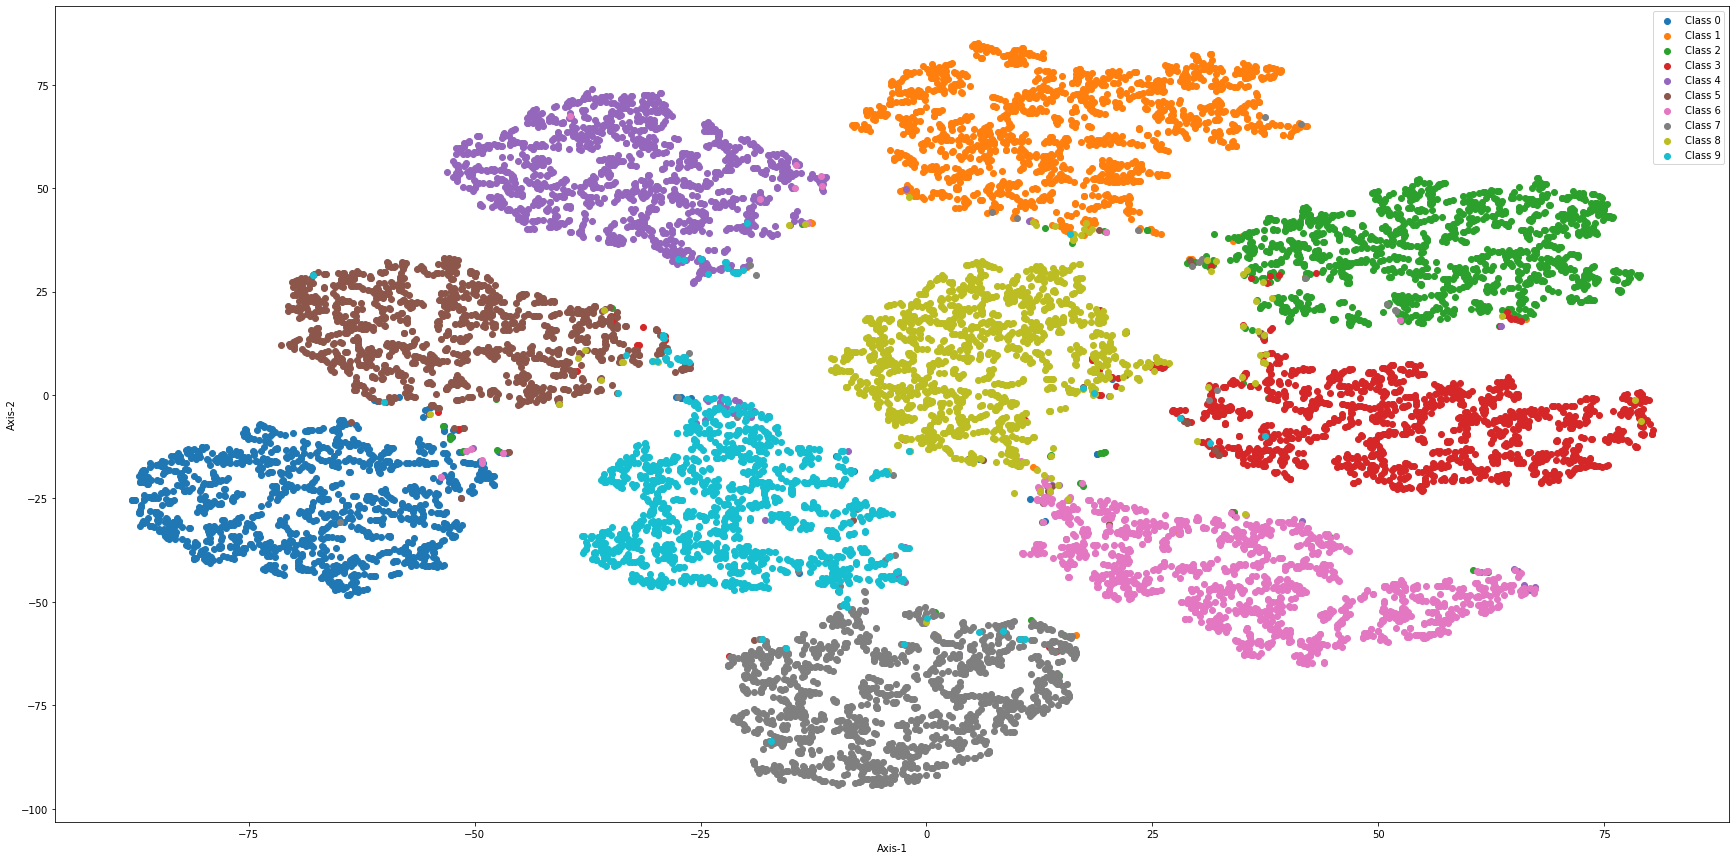

In [32]:
print(tsne)
plt.figure(figsize=(30,15))
for i in range(10):
    data = tsne[test_Y.T[i]==1]
    plt.scatter(data[:,0],data[:,1],label="Class "+str(i))
plt.xlabel("Axis-1")
plt.ylabel("Axis-2")
plt.legend()
plt.show()